In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [4]:
from models.hardnet_segm import HardNetSegm
import cv2
import torch
from models.bts_estimator import BTSEstimator
from plane_detector import PlaneDetector

In [5]:
from models.midas_estimator import MIDASEstimator

In [6]:
hardnet_path = "models/segmnetator/hardnet70_cityscapes_model_2.pkl"
bts_path = "models/depth_estimator/models/bts_latest"


depth_model = MIDASEstimator()
segm_model = HardNetSegm(hardnet_path)

Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ruslan/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master


In [7]:
model = PlaneDetector(depth_model, segm_model)

In [8]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.imread(path + item) for item in tqdm(files)]

100%|██████████| 267/267 [00:17<00:00, 15.10it/s]

CPU times: user 17 s, sys: 966 ms, total: 17.9 s
Wall time: 18.1 s


In [12]:
segm = []
for item in tqdm(images):
    _ = model.get_segm_map(item)
#     segm.append(1 / tt)
# sns.distplot(segm);

 15%|█▍        | 39/267 [00:09<00:57,  3.99it/s]


KeyboardInterrupt: 

In [48]:
from models.depth_estimator.BTS import BtsController
import numpy as np

img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/54_location_48.8877725,2.3276071/120/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")

seg_map = model.get_segm_map(img)
depth_map = model.get_depth_map(img)
# depth_img = BtsController.depth_map_to_rgbimg(depth_map)
        
vect_func = np.vectorize(lambda x: x in set([2]))
map_arr = vect_func(seg_map)

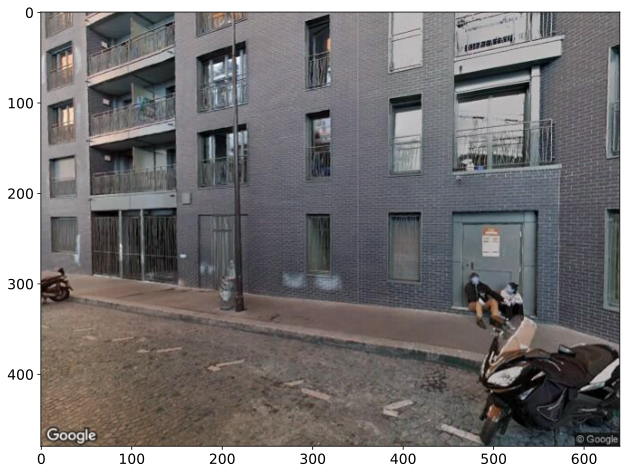

In [49]:
plt.imshow(img)

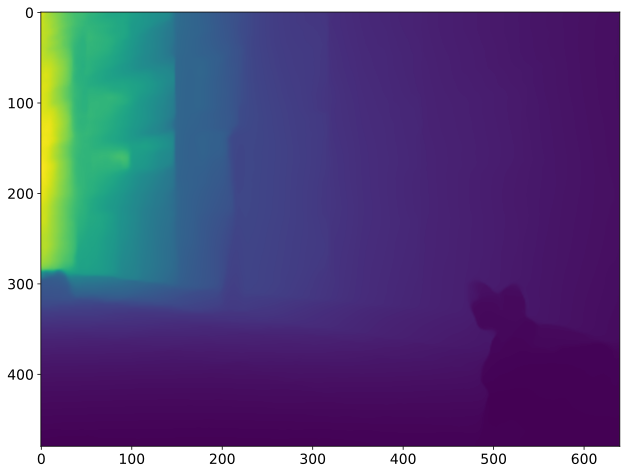

In [50]:
plt.imshow(1 / depth_map)

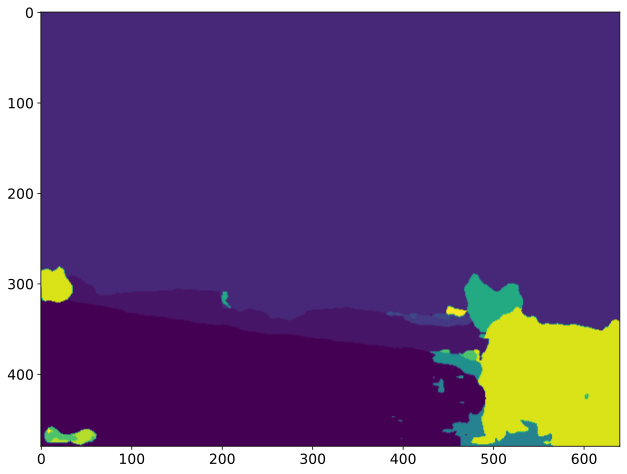

In [51]:
plt.imshow(seg_map)

In [52]:
import open3d as o3d
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

target = o3d.geometry.Image(np.array((1 / depth_map) * map_arr))


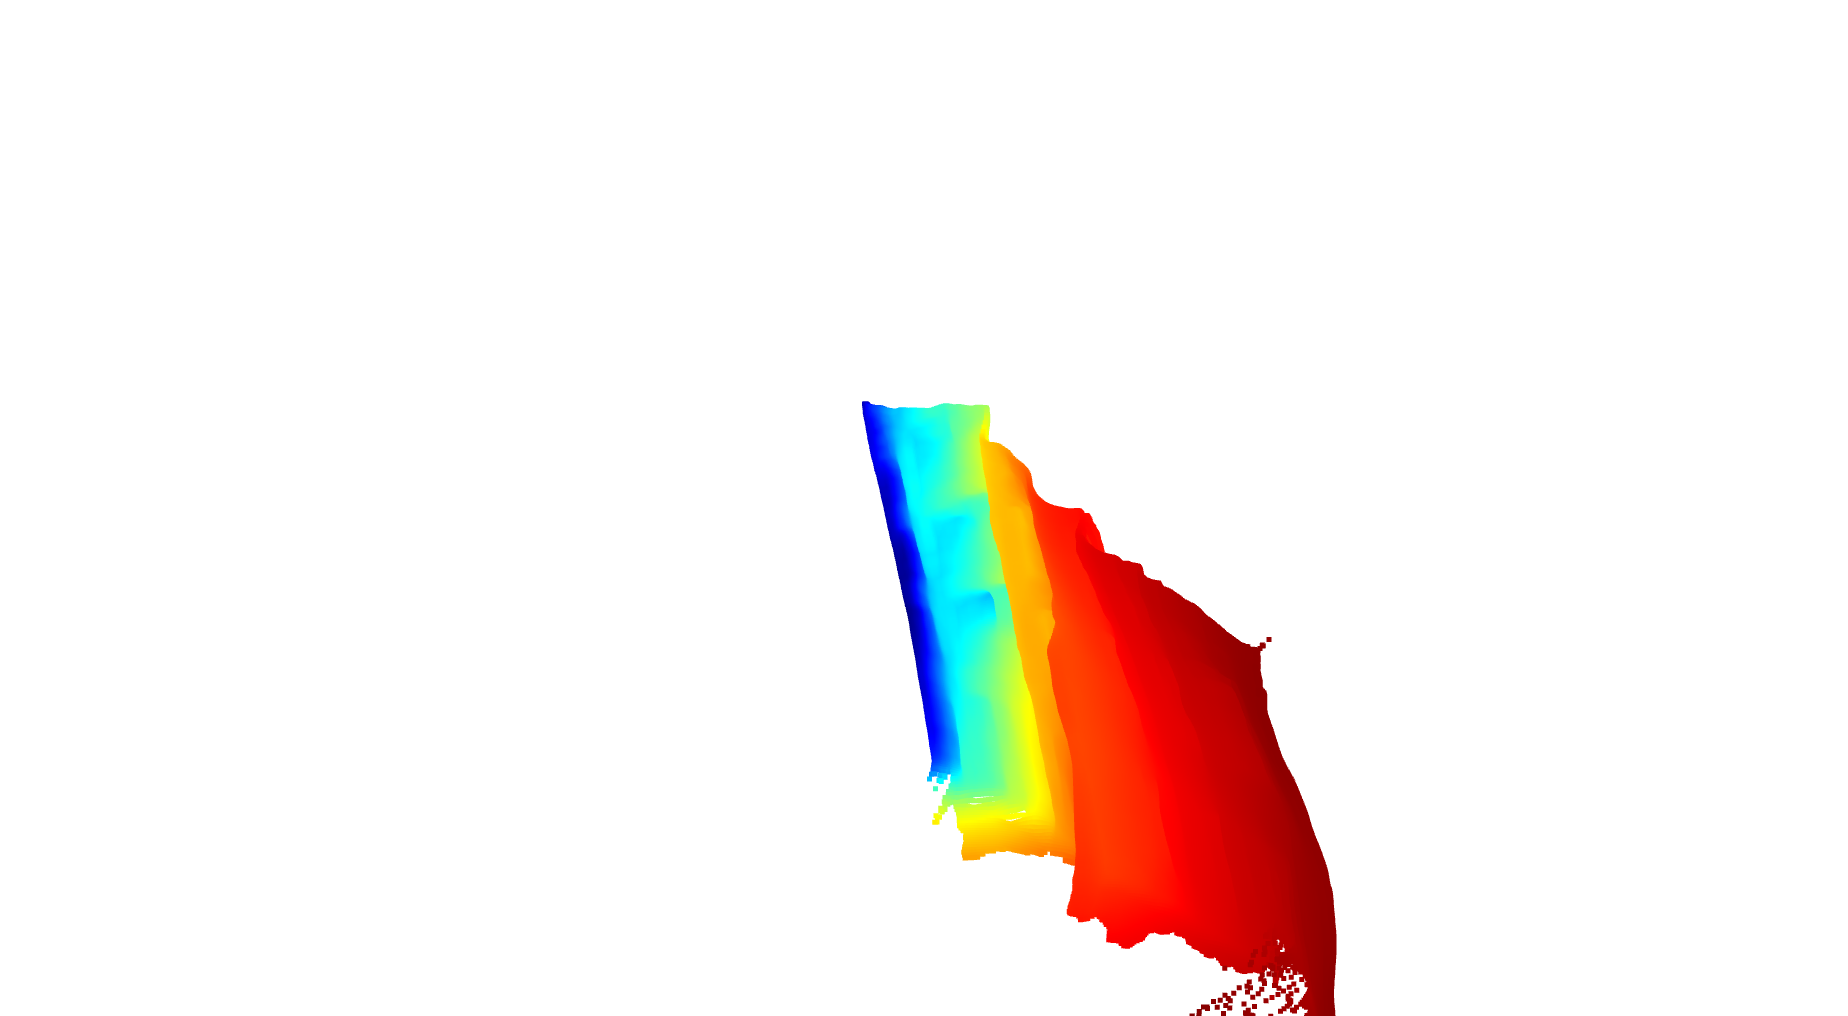

In [53]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    target,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)

In [54]:
from ransac_detector import *

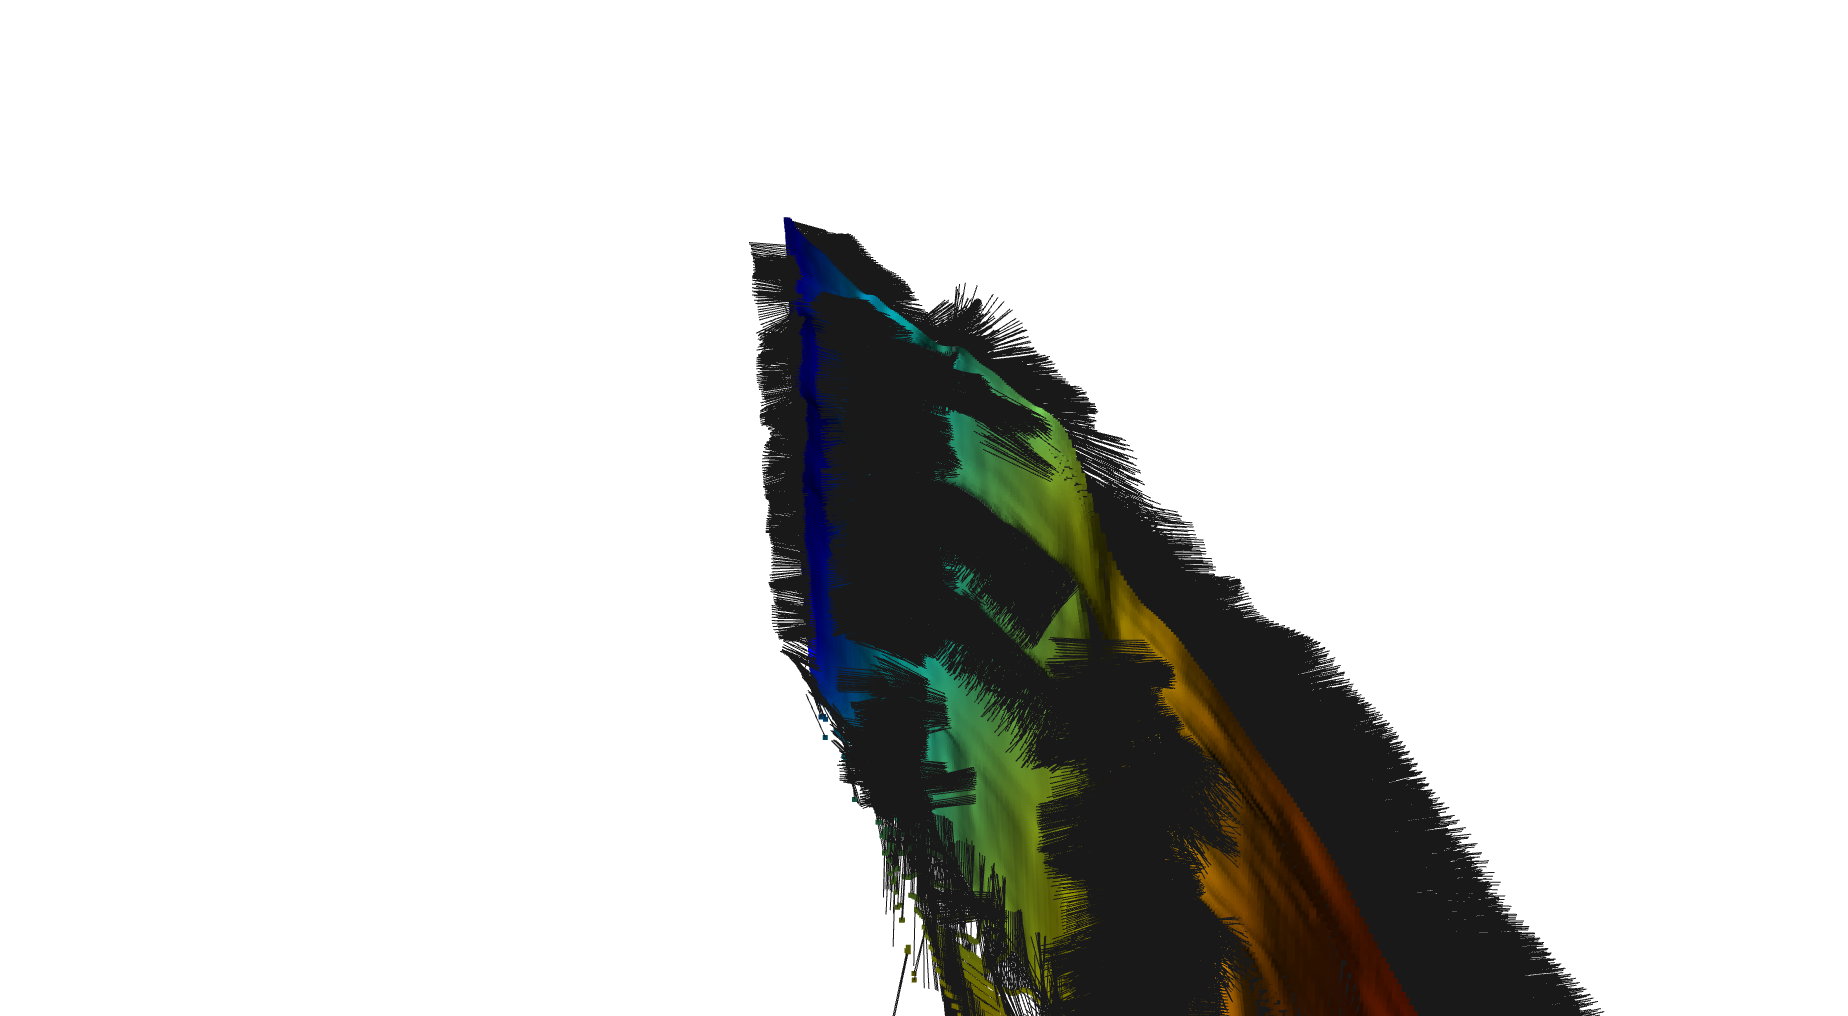

In [55]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([pcd], zoom=0.35)

Plane equation: 0.80x + -0.05y + -0.59z + -0.00 = 0


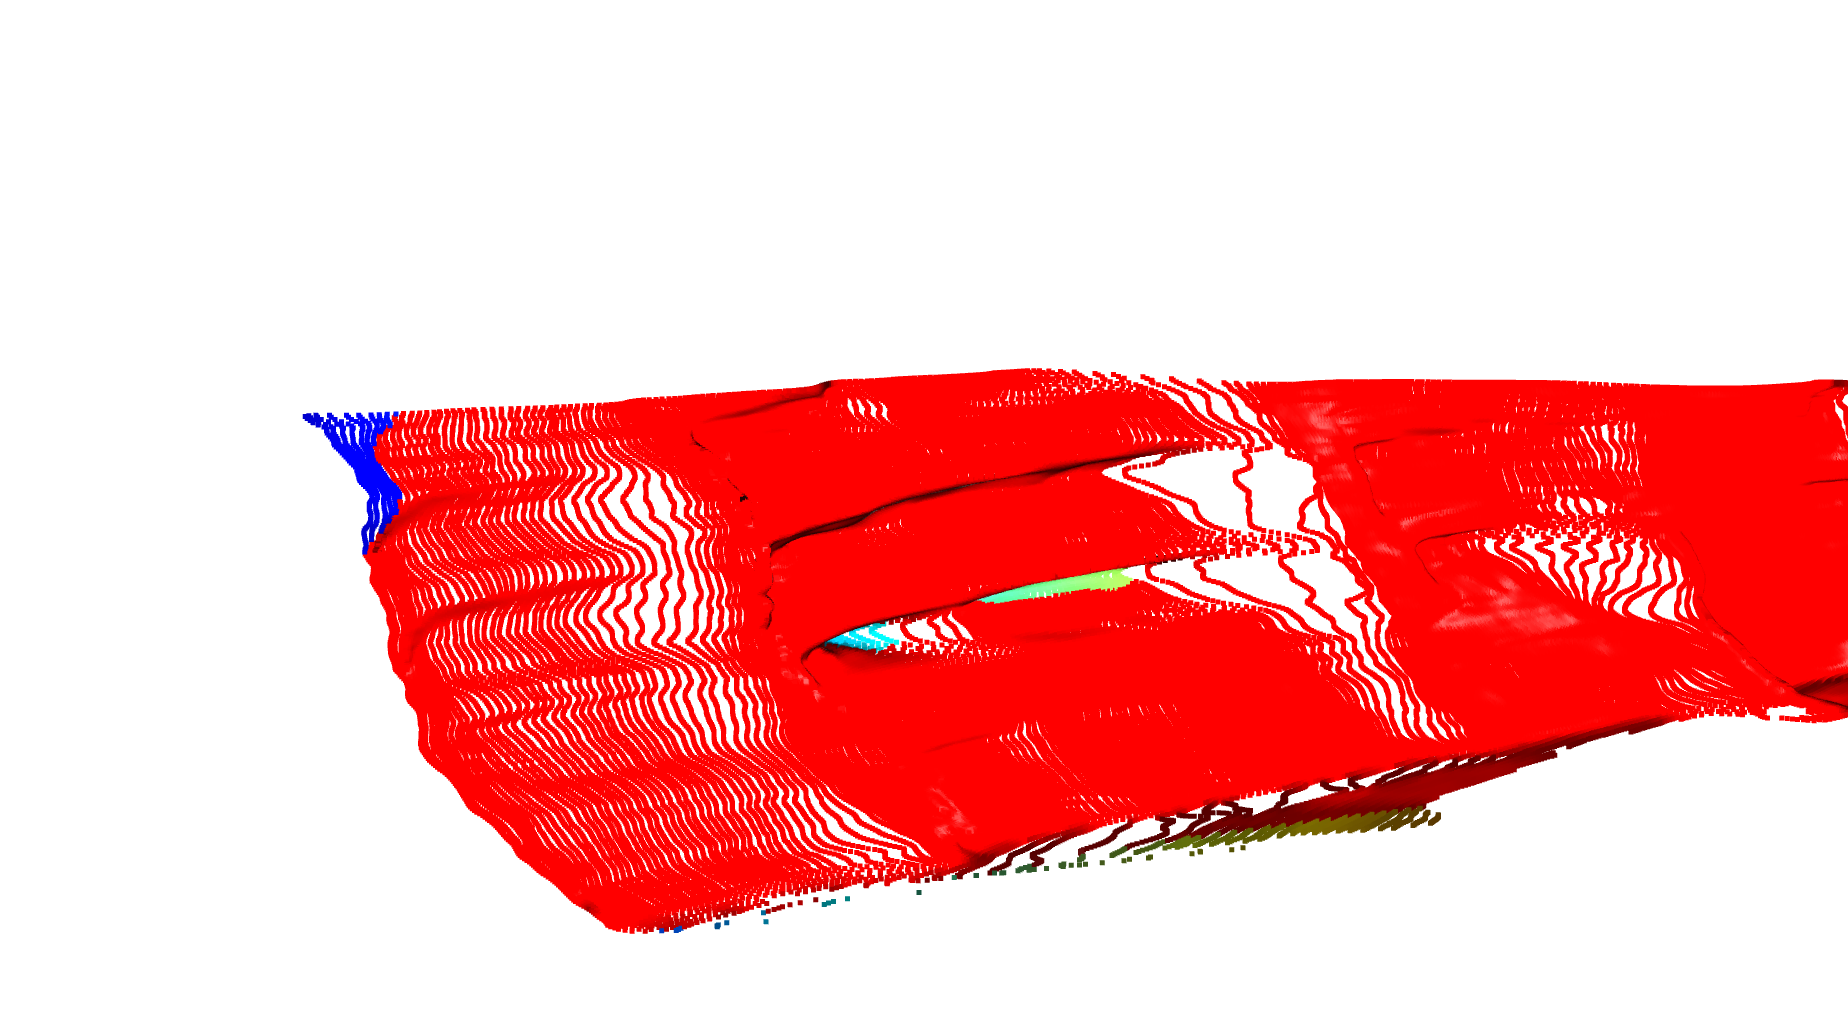

In [57]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.0001,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


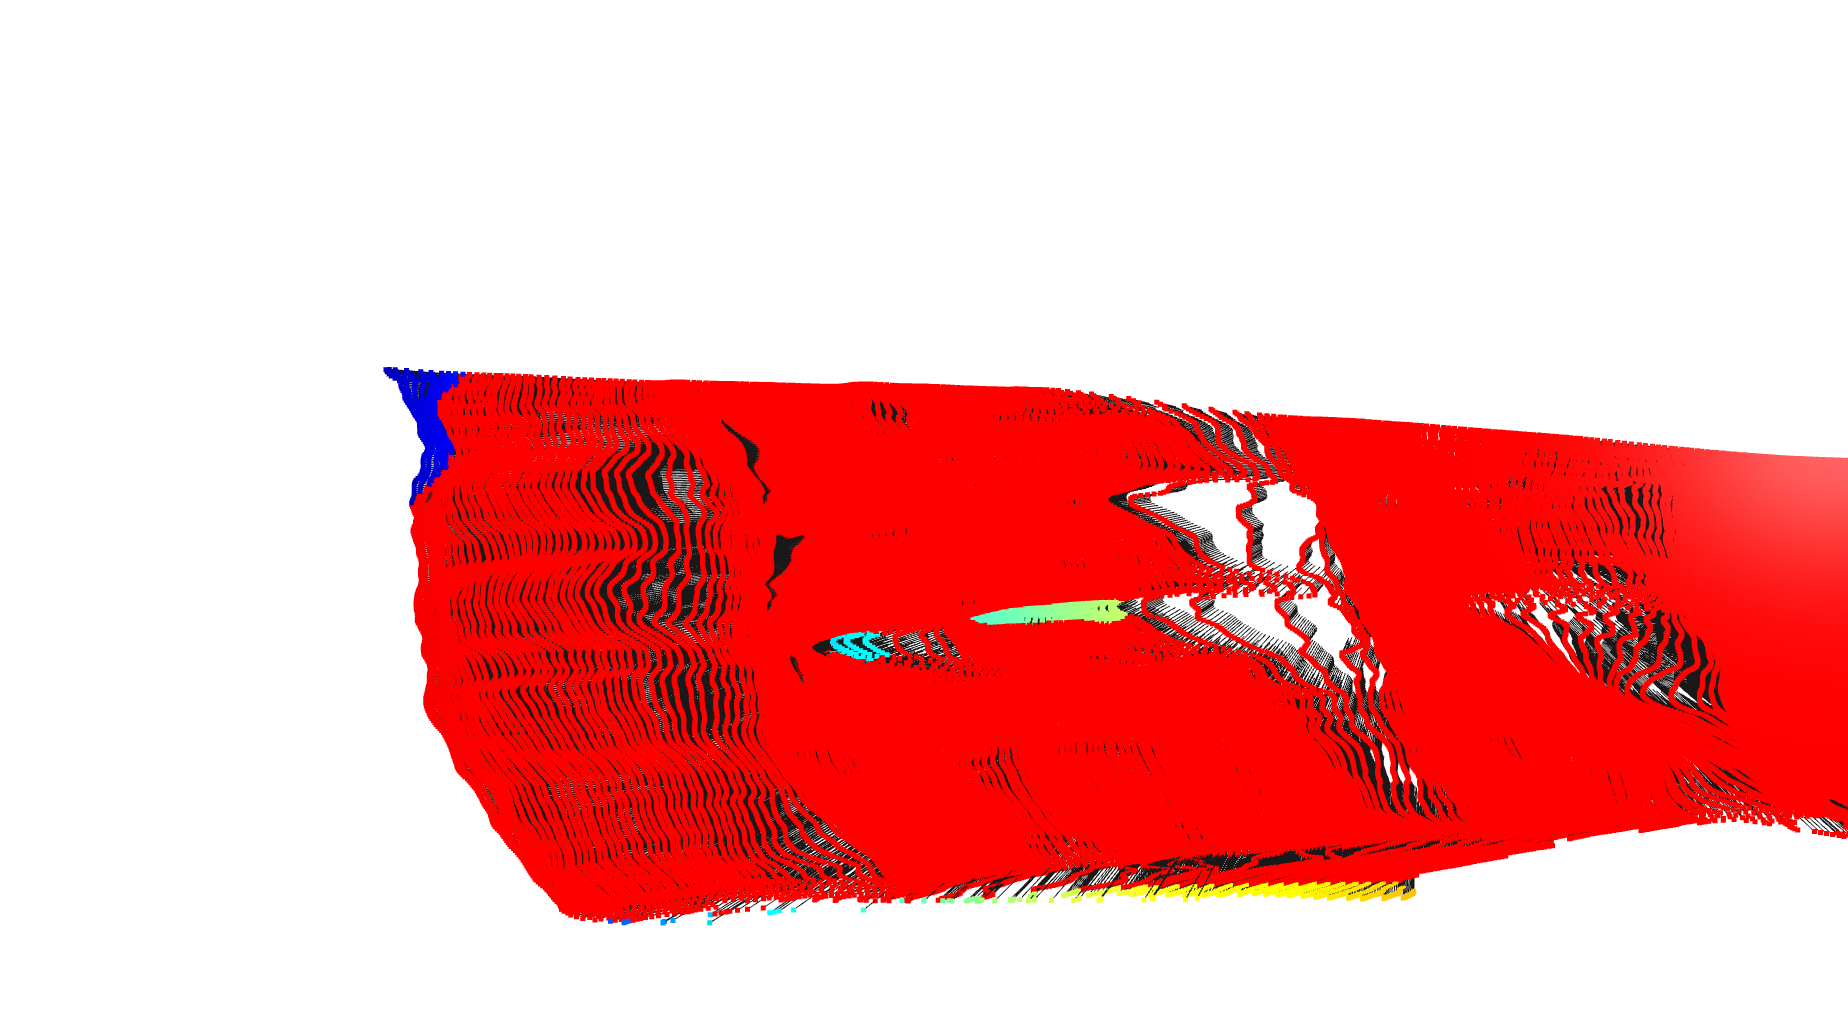

In [58]:
pcd.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(pcd.normals).shape[0])]))

inlier_cloud1 = pcd.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)